# ECE 5470 Lab 7 Report

    
    
## by Rufei Ye

## Part A Section 1

In section 1, I create my own dataset by writing 60 characters, and it will be used with a classifier trained on the MNIST dataset. The following is the process of creating and pre-processing the dataset.

Firstly, handwrite 60 characters (numbers 0-9, letters ABCDEVWXYZ) and upload them to jupyterhub, respectively. The following image shows the 30th handwritten character:6.

handwritten character:


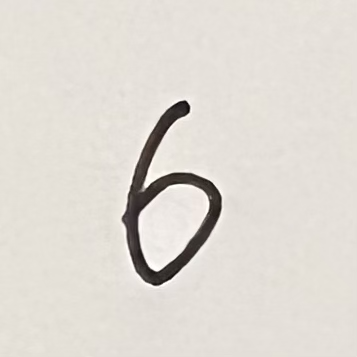

In [10]:
from PIL import Image
print("handwritten character:")
display(Image.open("./data/30.png"))

Next, a bash script named preprocess is created to traverse all the handwritten characters and perform a series of preprocessing instructions.

In [ ]:
# !/bin/sh
#
for i in {1..60..1};
do
vfmt -g if=./data/$i.png of=./data2/$i.vx
vpix if=./data2/$i.vx th=100 hi=0 lo=255 of=./data2/$(printf "%dt" "$i").vx
vbbx if=./data2/$(printf "%dt" "$i").vx of=./data2/$(printf "%db" "$i").vx
vimag if=./data2/${i}b.vx s=20,20,1 of=./data2/${i}_vimg.vx
COM28 if=./data2/${i}_vimg.vx of=./data2/${i}_28.vx
vxport if=./data2/${i}_28.vx -png of=./idata/${i}.png
done

In the preprocessing script, firstly, vfmt command is used to convert the image from png format to vx format for subsequent command work. Next, vpix command is used to threshold the images to make binary (bilevel) images. vbbx command completes the function that find the bounding of the character. vbbx python script is shown as following.

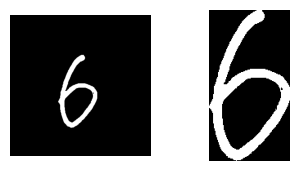

the 30th character:6 after threshold & with bounding box
<scaled size: (357 x 357) (185 x 99) >


In [16]:
import numpy as np
from v4 import vx
from v4 import vd
vd.dispmvx('./data2/30t.vx', './data2/30b.vx',size=0.5,capt='the 30th character:6 after threshold & with bounding box')

In [ ]:
#!/usr/bin/env python

"""
vbbx.py: find the bounding box of the character

"""

import numpy as np
from v4 import vx

# parse command parameters
vargs = vx.vaparse("if= of= s=  -")

if '-' in vargs:
   print ("vbbx:find the bounding box of the character ")
   print ("if= input file")
   print ("of= output file")
   exit()

# read input image
if 'if' in vargs:
   inimage = vx.Vx(vargs['if'])
else:
   print ( 'vbbx  error: if= must be specified')
   exit()
im = inimage.i
if im.dtype != 'uint8' :
    print ("vbbx error: image not byte type", file=sys.stderr)
    exit(1)

# check for output file name
if 'of' not in vargs:
   print ( 'vbbx error: of= must be specified')
   exit()

# create output image with the size of the selected region
tmimage = vx.Vx() 
x_min = 1000
x_max = 0
y_min = 1000
y_max = 0

for y in range(im.shape[0]):
    for x in range(im.shape[1]):
        if(im[y][x]>0):
            y_min=min(y_min,y)
            y_max=max(y_max,y)
            x_min=min(x_min,x)
            x_max=max(x_max,x)

tm=np.zeros((y_max-y_min+1,x_max-x_min+1),dtype='uint8')
tmimage.i = tm
for y in range(y_max - y_min+1):
    for x in range(x_max - x_min+1):
        tm[y][x] = im[y+y_min][x+x_min] 

# Write the output files
tmimage.write(vargs['of'])


In vbbx program, the algorithm finds the largest and smallest non-zero pixel as the boundary of the clipping. And then vimag is used to map the image into a 20 x 20 new image space and complete the interpolation of the binary image. Finally, COM28 is a new designed python script to compute the center of mass (COM) then translate copy the image to an image of size 28 x 28 such that the COM is in the center. COM28 python script is shown as following. vxport command is used to convert VisionX image file format to png format. 

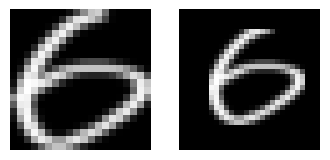

the 30th character:6 in 20x20 space & in 28x28 space with interpolation
<scaled size: (20 x 20) (28 x 28) >


In [19]:
vd.dispmvx('./data2/30_vimg.vx', './data2/30_28.vx',size=0.5,capt='the 30th character:6 in 20x20 space & in 28x28 space with interpolation')

In [ ]:
#!/usr/bin/env python

"""
COM28.py: compute the center of mass (COM) then translate copy image to an image of size 28 x 28 

"""

import numpy as np
from v4 import vx

# parse command parameters
vargs = vx.vaparse("if= of= s=  -")

if '-' in vargs:
   print ("COM28 ")
   print ("if= input file")
   print ("of= output file")
   exit()

# read input image
if 'if' in vargs:
   inimage = vx.Vx(vargs['if'])
else:
   print ( 'COM28  error: if= must be specified')
   exit()
im = inimage.i
if im.dtype != 'uint8' :
    print ("COM28 error: image not byte type", file=sys.stderr)
    exit(1)

# check for output file name
if 'of' not in vargs:
   print ( 'COM28 error: of= must be specified')
   exit()

tmimage = vx.Vx() 
xsum=0
count=0
ysum=0

#calculate COM
for y in range(im.shape[0]):
    for x in range(im.shape[1]):
        if(im[y][x]>0):
            count = count +1
            ysum = ysum +y
            xsum = xsum +x
ycom = ysum/count
ycom = int(ycom)
xcom = xsum/count 
xcom = int(xcom)

tm=np.zeros((28, 28),dtype='uint8')
tmimage.i = tm
for y in range(tm.shape[0]):
    for x in range(tm.shape[1]):
        if y+ycom-13 > 0 and x+xcom-13 > 0 and y+ycom-13 < 20 and x+xcom-13 < 20:
            tm[y,x] = im[y+ycom-13, x+xcom-13]

# Write the output files
tmimage.write(vargs['of'])


All the new png images are stored in a local directory called idata and a csv index file named labels.csv is created to describe the contents. (The complete dataset will display in section2.)

To explore the impact of line thickness on performance, a second dataset is made with a different line thickness. After visually comparing my dataset with examples form the MNIST dataset. Except for the number 1, all other characters are thinner than those in the NMIST dataset. As a result, I change the line thickness of image6-60 by a small amount. A new bash script is created to repeat the preprocessing of the above dataset with a new step between thresholding and interpolation that modifies the thickness of the character lines. The new step is using vmorph command to dilate the character. The new bash script is shown as following. All the new images are stored in a new directory named idata2, and also with the same index file. (The complete dataset will display in section2.)

In [ ]:
# !/bin/sh
#
for i in {6..60..1};
do
vfmt -g if=./data/$i.png of=./data3/$i.vx
vpix if=./data3/$i.vx th=100 hi=0 lo=255 of=./data3/${i}t.vx
vmorph if=./data3/${i}t.vx -d of=./data3/${i}td.vx s=6,6,6
vbbx if=./data3/${i}td.vx of=./data3/${i}b.vx
vimag if=./data3/${i}b.vx s=20,20,1 of=./data3/${i}_vimg.vx
COM28 if=./data3/${i}_vimg.vx of=./data3/${i}_28.vx
vxport if=./data3/${i}_28.vx -png of=./idata2/${i}.png
done

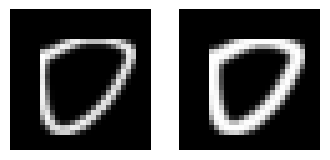

the 50th character:0 in idata & in idata2
<scaled size: (28 x 28) (28 x 28) >


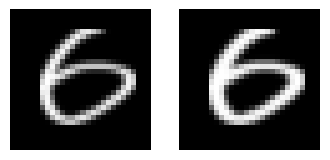

the 30th character:6 in idata & in idata2
<scaled size: (28 x 28) (28 x 28) >


In [25]:
vd.dispmvx('./data2/50_28.vx', './data3/50_28.vx',size=0.5,capt='the 50th character:0 in idata & in idata2')
vd.dispmvx('./data2/30_28.vx', './data3/30_28.vx',size=0.5,capt='the 30th character:6 in idata & in idata2')

##  Part A, Section 2

At first, the classifier is trained and tested by the standard test dataset.

In [2]:
#1 import required modules
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen

In [44]:
#2.  read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()


The dataset is scaled by dividing with 255 to make sure that it has a value in the 0-255 range. The dataset is then split into training and testing set.

In [45]:
# rescale the data, use the traditional train/test split

X = X / 255.

###### NEW  Refromat the the labels to be string rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(y[i].decode("utf-8"))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


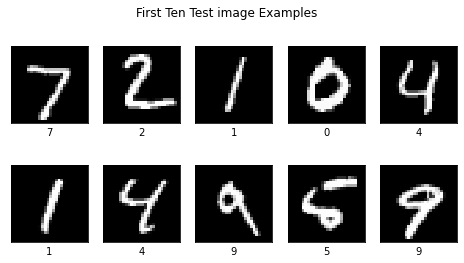

In [46]:
### Bounus 1: show the first ten images
### ALways a good idea to validate that the data appears as you expect
### for sci-kit learn the images are represented as vectors of 784 elements
### currently scaled from 0 to 1

for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i' % int(y_test[i]))
plt.suptitle('First Ten Test image Examples')
plt.show()

In [47]:
## for this demonstration each pixel scale is normalized 
## by the mean and standared deviation of the training set
## note the mean and stadard deviation are set by the taining set only.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The StandardScaler() function serves to standardize the features in the training and test sets by removing the mean and scaling the standard deviation/variance. This makes the data centered with similar variance scales. The mean and variance are chosen based on the training set and will be used in both the training and test sets. The training set is normalized so that no one feature can dominate the model, which results in other features having no impact/contribution to the prediction. The test set uses the same mean and variance because it is expected that all data sets will be shifted and scaled by the same numbers.

In [48]:
#train and test classifier
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000, multi_class='multinomial', penalty='l1', solver='saga', tol=0.1)
# Train the classifier
clf.fit(X_train, y_train)

#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
y = clf.predict(X_test)

print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y)
print("y_labels", y_test)

Sparsity with L1 penalty: 16.57%
Test score with L1 penalty: 0.8910
y_predicted_values ['7' '2' '1' ... '4' '5' '6']
y_labels ['7' '2' '1' ... '4' '5' '6']


The Logistic Regression classifier is created with c that affects the regularization to be 0.05, have a multinomial classification, and penalty L1. The classifier is trained based on the MNIST training set. The accuracy of the classifier for the test dataset is 89.10%, and the sparsity is 16.57%. The overall result is good and it works well for the MNIST dataset.

In [52]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_predict)
print (cfm)

[[ 949    0    1    2    0   12   12    1    3    0]
 [   0 1103    3    3    1    2    4    0   19    0]
 [  16   21  869   23   19    0   18   23   40    3]
 [   6    7   19  893    1   30    8   18   20    8]
 [   2   10    4    0  902    2   14    2    3   43]
 [  13    9    6   44   23  723   21   14   25   14]
 [  16    9    8    0   11   18  891    1    4    0]
 [   1   34   18    5   12    0    1  915    1   41]
 [  10   31    9   29   20   38    9   17  795   16]
 [  18   10    4   13   53    6    0   32    3  870]]


In [50]:
### Bonus 3: comfusion matrix visualization tool
## A more elegant preserntation for a confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization


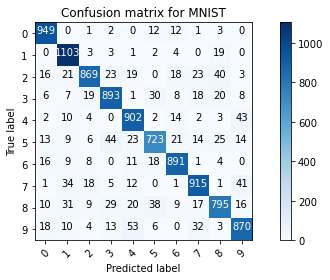

In [53]:
plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for MNIST')

The confusion matrix above( original matrix and the elegant one) vividly shows the performance of the Logistic Regression classifier.Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. In the matrix, the numbers on the diagonal are larger and have distinct dark blue color blocks. It shows that this algorithm does a good job of predicting the labels of the characters.

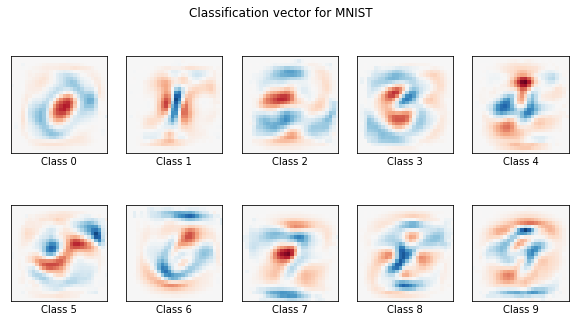

In [49]:
# Bonus 2: Visualization of the weights
# This is only possible for simple classifiers

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for MNIST')
plt.show()


The above image shows the weights of ten classes in the MNIST dataset. 0-9 characters are faintly visible in the blue part of the image.

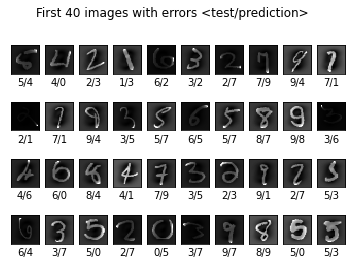

In [12]:
#Plot the images from the standard MNIST test set of the first 40 images with errors together 
#with the correct and incorrect labels. 
n=0;
i=0;
while n < 40:
    if (y_test[i]!=y_predict[i]):
        l2_plot = plt.subplot(4, 10, n + 1)
        l2_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',cmap=plt.cm.gray)
        l2_plot.set_xticks(())
        l2_plot.set_yticks(())
        l2_plot.set_xlabel('%i/%i' % (int(y_test[i]),int(y_predict[i])))
        n+=1
    i+=1
plt.suptitle('First 40 images with errors <test/prediction>')
plt.show()

Above are the images from the standard MNIST test set of the first 40 images with errors together with the correct and incorrect labels. These images have a few things in common. First of all, part of the picture is very blurry. A lot of black shadows make them hard to distinguish. Second, many characters are skewed, such as the fourth and penultimate in the first line. Third, many of the characters are not written in a standard way, for example, the last 5 in the third line loses the top cross. The handwritten characters pose a challenge to the classification model. However, the model still performs well for the score of 89.17%.

Next, my new datasets are used to test and evaluate the performance of the classifier.

In [13]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.loc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

In [14]:
mydata = SimpleDataset( "./idata/", "labels.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


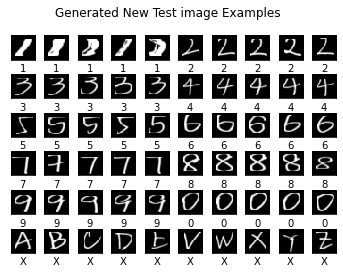

In [15]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l1_plot = plt.subplot(6, 10, i + 1)
    l1_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('%s' % (y[i]))
    plt.subplots_adjust(wspace =0, hspace =0.6)
plt.suptitle('Generated New Test image Examples')
plt.show()

This is my first handwritten dataset after preprocessing. As discussed before, the first five characters are very thick and the others are very thin, which has been optimized in dataset2.

In [16]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Test score with L1 penalty: 0.4500
y_predicted_values ['8' '8' '2' '1' '2' '2' '2' '2' '2' '2' '7' '3' '3' '0' '0' '1' '4' '4'
 '4' '1' '5' '3' '4' '5' '5' '6' '6' '5' '6' '0' '7' '4' '7' '7' '7' '8'
 '3' '5' '2' '4' '9' '7' '9' '4' '7' '0' '0' '5' '0' '5' '4' '0' '5' '0'
 '5' '4' '4' '5' '7' '3']
y_labels ['1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '4' '4' '4'
 '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '0' '0' '0' '0' '0' 'X' 'X' 'X' 'X'
 'X' 'X' 'X' 'X' 'X' 'X']


The accuracy of the classifer working on the new dataset is 45%, which is lower than the result of the MNIST dataset.

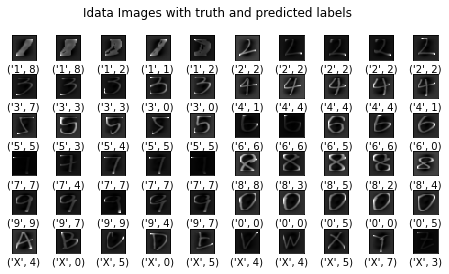

In [37]:
warnings.filterwarnings('ignore')
for i in range(60):
    l1_plot = plt.subplot(6, 10, i + 1)
    l1_plot.imshow(255 * X[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    xlabel = str(y[i]),int(y_pred[i])
    l1_plot.set_xlabel(xlabel)
    plt.subplots_adjust(wspace =0, hspace =0.6)
plt.suptitle('Idata Images with truth and predicted labels')
plt.show()

As shown in the images, the characters in the last line are not numbers so it reduces the correct rate to some extent. Of the other characters, the number 1 has the most errors, perhaps because it is too thick. The number 8 contains curves and complex structures, so the prediction is not as good. Correspondingly, the number 7 has a simple line and looks easier for the classifier to identify. The classifier performs best with the number 2.

Finally, the classifer will work on the thicker dataset: idata2, which is more similar to the MNIST dataset.

In [54]:
mydata = SimpleDataset( "./idata2/", "labels.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


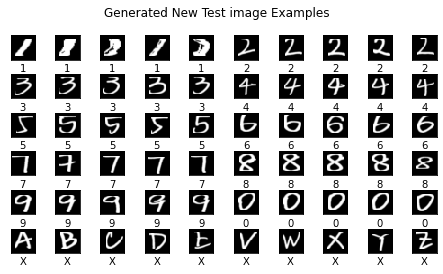

In [55]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l1_plot = plt.subplot(6, 10, i + 1)
    l1_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('%s' % (y[i]))
    plt.subplots_adjust(wspace =0, hspace =0.6)
plt.suptitle('Generated New Test image Examples')
plt.show()

In [56]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Test score with L1 penalty: 0.4833
y_predicted_values ['8' '8' '2' '1' '2' '2' '2' '2' '2' '2' '3' '3' '3' '0' '0' '9' '4' '9'
 '4' '9' '5' '3' '4' '5' '5' '6' '6' '5' '0' '0' '7' '4' '7' '7' '7' '8'
 '3' '3' '2' '4' '9' '9' '9' '4' '7' '0' '0' '0' '0' '0' '9' '0' '0' '0'
 '6' '4' '4' '5' '7' '3']
y_labels ['1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '4' '4' '4'
 '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '0' '0' '0' '0' '0' 'X' 'X' 'X' 'X'
 'X' 'X' 'X' 'X' 'X' 'X']


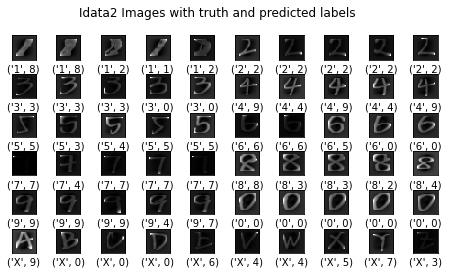

In [57]:
warnings.filterwarnings('ignore')
for i in range(60):
    l1_plot = plt.subplot(6, 10, i + 1)
    l1_plot.imshow(255 * X[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    xlabel = str(y[i]),int(y_pred[i])
    l1_plot.set_xlabel(xlabel)
    plt.subplots_adjust(wspace =0, hspace =0.6)
plt.suptitle('Idata2 Images with truth and predicted labels')
plt.show()

The accuracy of the classifer working on the dataset: idata2 is 48.33%, which is better than the result of the first handwritten dataset. The prediction of the number 2 maintains the original correct rate, while the number 0 has a much higher correct rate. The bold font is more visible. In the idata2 test, the classifier's errors were more concentrated. For example, the handwritten number 4 can easily be confused for 9, perhaps because this writing style makes the two numbers too similar in structure. In addition, some characters lost some pixels during the preprocessing process, so that the characters were not complete and the results were not satisfactory. Since the model is trained with the MNIST dataset, the more similar the handwritten dataset is to it, the higher the accuracy of label prediction.

## Part B, Section 3

In [1]:
#Importing required libraries

import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

### Dataset loading and preprocessing:

In [2]:
#Load the MNIST dataset here
import time
import io
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from joblib import Memory
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from urllib.request import urlopen

memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()


In [3]:
# rescale the data, use the traditional train/test split

X = X / 255.

###### NEW  Refromat the the labels to be string rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(y[i].decode("utf-8"))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


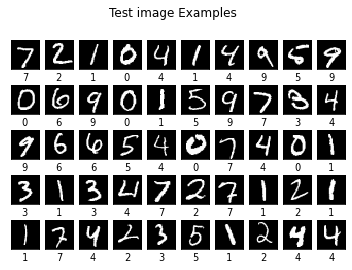

In [28]:
for i in range(50):
    l1_plot = plt.subplot(5, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i' % int(y_test[i]))
plt.suptitle('Test image Examples')
plt.show()

### 3.1 K-NN model

In [5]:
# KNN 
def KNN(train_features, train_labels, test_features, test_labels, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(train_features,train_labels)
    train_time = time.time() - start_time
    start_time = time.time()
    print(k)
    score_t = knn.score(train_features,train_labels)
    print(f'Training time {train_time} seconds for {k}NN')
    print(f'Training score with {k}NN is: {score_t}')
    #Evaluate the result
    score = knn.score(test_features,test_labels)
    test_time = time.time() - start_time
    print(f'Test time {test_time} seconds')
    print(f'Test score with {k}NN is: {score}')
    from sklearn.metrics import confusion_matrix
    y_predict = knn.predict(test_features)
    cfm = confusion_matrix(test_labels, y_predict)
    print (cfm)
    plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix with {k}NN')

1
Training time 16.121621131896973 seconds for 1NN
Training score with 1NN is: 1.0
Test time 4417.54612326622 seconds
Test score with 1NN is: 0.9691
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   7    6  992    5    1    0    2   16    3    0]
 [   0    1    2  970    1   19    0    7    7    3]
 [   0    7    0    0  944    0    3    5    1   22]
 [   1    1    0   12    2  860    5    1    6    4]
 [   4    2    0    0    3    5  944    0    0    0]
 [   0   14    6    2    4    0    0  992    0   10]
 [   6    1    3   14    5   13    3    4  920    5]
 [   2    5    1    6   10    5    1   11    1  967]]
Confusion matrix, without normalization


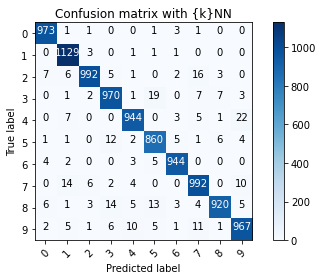

In [6]:
#Example with K=1 and full data
KNN(X_train, y_train, X_test, y_test, 1)

1
Training time 1.0747084617614746 seconds for 1NN
Training score with 1NN is: 1.0
Test time 147.66115522384644 seconds
Test score with 1NN is: 0.9507803121248499
[[166   0   0   0   0   0   2   0   0   0]
 [  0 192   2   0   0   0   0   0   0   0]
 [  1   3 153   0   0   0   0   2   1   0]
 [  0   1   5 152   0   1   0   3   4   1]
 [  0   1   0   0 158   0   1   2   0   9]
 [  1   0   0   4   0 144   2   0   2   0]
 [  3   0   0   0   0   1 152   0   0   0]
 [  0   0   0   0   1   0   0 171   1   2]
 [  0   4   0   5   2   0   1   1 131   2]
 [  0   0   0   0   7   1   0   3   0 165]]
Confusion matrix, without normalization


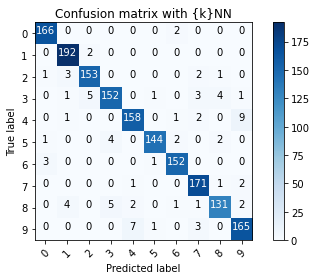

In [30]:
#Partition data into different train and test sets
#1/6 data K=1
first_index = int(60000/6)
second_index = int(60000/6+10000/6)
X_train, X_test = X[:first_index], X[first_index:second_index]
y_train, y_test = y[:first_index], y[first_index:second_index]
KNN(X_train, y_train, X_test, y_test, 1)

3
Training time 0.927239179611206 seconds for 3NN
Training score with 3NN is: 0.9755
Test time 223.96061897277832 seconds
Test score with 3NN is: 0.9585834333733494
[[166   0   0   0   0   0   1   0   0   1]
 [  0 192   2   0   0   0   0   0   0   0]
 [  2   4 153   0   0   0   0   1   0   0]
 [  0   1   6 154   0   1   0   2   2   1]
 [  0   1   0   0 163   0   1   0   0   6]
 [  0   0   0   3   0 146   3   0   1   0]
 [  2   0   0   0   0   1 153   0   0   0]
 [  0   0   0   0   0   0   0 173   1   1]
 [  0   4   1   5   2   0   1   1 130   2]
 [  0   1   0   3   4   0   0   1   0 167]]
Confusion matrix, without normalization


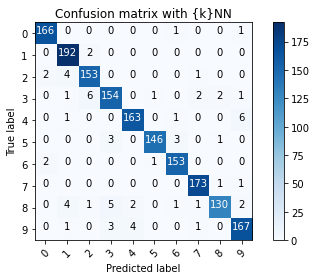

In [31]:
# K=3 and 1/6 data
KNN(X_train, y_train, X_test, y_test, 3)

In [35]:
#PCA
###Apply PCA after data splitting and standardization.
first_index = int(60000/3)
second_index = int(60000/3+10000/3)
X_train, X_test = X[:first_index], X[first_index:second_index]
y_train, y_test = y[:first_index], y[first_index:second_index]

#Wisely choose the number of components (n_components) or the amount of variance retained. 
pca = PCA(n_components=40)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


1
Training time 0.13578581809997559 seconds for 1NN
Training score with 1NN is: 1.0
Test time 1.524991750717163 seconds
Test score with 1NN is: 0.9570957095709571
[[324   0   1   0   0   1   1   0   0   0]
 [  0 368   2   0   0   2   1   0   1   0]
 [  2   0 338   3   0   1   1   5   3   1]
 [  0   1   3 337   0   6   0   0   5   2]
 [  0   0   0   0 315   1   1   3   1  18]
 [  1   1   1   3   0 282   1   0   3   1]
 [  0   2   0   1   1   4 320   0   1   0]
 [  0   2   2   0   2   0   0 318   0   3]
 [  1   1   1   6   0   4   3   1 278   7]
 [  2   1   1   2   8   1   0   9   0 310]]
Confusion matrix, without normalization


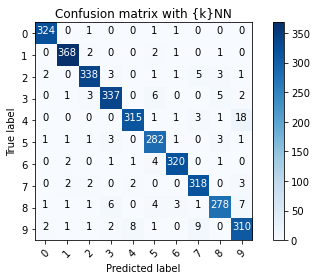

In [34]:
#PCA：n=20, K=1, 1/3data
KNN(X_train, y_train, X_test, y_test, 1)

1
Training time 0.11761760711669922 seconds for 1NN
Training score with 1NN is: 1.0
Test time 2.8083271980285645 seconds
Test score with 1NN is: 0.9672967296729673
[[325   0   1   0   0   0   1   0   0   0]
 [  0 368   2   1   0   1   1   0   1   0]
 [  3   0 335   3   0   0   1   9   2   1]
 [  0   1   2 342   0   3   0   0   5   1]
 [  0   0   0   0 324   0   0   2   1  12]
 [  1   1   0   3   0 284   1   0   1   2]
 [  1   2   0   1   1   3 320   0   1   0]
 [  0   2   3   1   1   0   0 319   0   1]
 [  1   1   1   3   0   1   1   2 290   2]
 [  1   0   0   1   5   1   0   8   1 317]]
Confusion matrix, without normalization


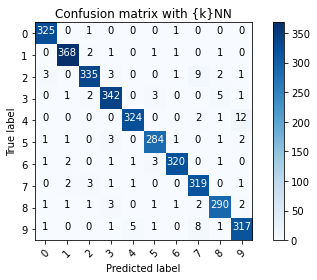

In [36]:
#PCA：n=40, K=1, 1/3data
KNN(X_train, y_train, X_test, y_test, 1)

**Discussion**
<table>
  <tr>
    <th>Data</th>
    <th>K</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>Full</td>
    <td>1</td>
    <td>21.59</td>
    <td>100</td>
    <td>1025.75</td>
    <td>96.91</td>
  </tr>
    <tr>
    <td>1/3</td>
    <td>1</td>
    <td>2.55</td>
    <td>100</td>
    <td>525.20</td>
    <td>96.25</td>
  </tr>
    <tr>
    <td>1/6</td>
    <td>1</td>
    <td>1.07</td>
    <td>100</td>
    <td>147.66</td>
    <td>95.08</td>
  </tr>
    <tr>
    <td>1/6</td>
    <td>3</td>
    <td>0.93</td>
    <td>97.55</td>
    <td>223.96</td>
    <td>95.86</td>
  </tr>
</table>
First, I tested the performance of the full, one-third and one-sixth data sets for k = 1, respectively. Experimenting with the full dataset can be time consuming and the length of time depends on the availability of the server. Although the number of testing sets is larger than the training sets, testing takes more time than training. When k=1, all the training scores are 100, while the dataset gets smaller, the test score becomes lower. Also, selecting partial datasets saves time. When k=3, the training score is a little lower, and it takes more time to test the dataset as there are more points to compare with. And the result improves a little. In conclusion, KNN works well on the MNIST dataset, the biggest difference is the distinction in time consumption.


<table>
  <tr>
    <th>Data(1/3,with PCA)</th>
    <th>K</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
    <tr>
    <td>n=10</td>
    <td>1</td>
    <td>0.034</td>
    <td>100</td>
    <td>0.81</td>
    <td>90.28</td>
  </tr>
    <tr>
    <td>n=20</td>
    <td>1</td>
    <td>0.14</td>
    <td>100</td>
    <td>1.52</td>
    <td>95.71</td>
  </tr>    
   <tr>
    <td>n=40</td>
    <td>1</td>
    <td>0.12</td>
    <td>100</td>
    <td>2.80</td>
    <td>96.72</td>
  </tr>    
   <tr>
    <td>n=40</td>
    <td>3</td>
    <td>0.034</td>
    <td>98.47</td>
    <td>25.80</td>
    <td>96.43</td>
  </tr>
</table>

Next, I apply PCA before running KNN function. I set the number of components = 20 with 1/3 dataset, and try different number of neighbors. As before, only when k=3, there is a case where the training score is not 100, and it takes more time than k=1. 
From the table above, we can see how performing PCA alows us to have lower training and testing time, and sometimes a higher accuracy. When n=20, the training and testing times are much lower than the previous data, but the accuracy is reduced by 0.5 . When n=10, perhaps because the dimensionality is reduced too much, the accuracy is also reduced although the speed is particularly fast. When n increases to 40, the speed improvement is smaller than 20, but the accuracy is also slightly improved. In sum, PCA decompose the data into a set of orthogonal components that will maximize the amount of variance, which really helps in having a quick training and testing. 


### 3.2 Multi Layer Perceptron 


In [40]:
#MLP model
def MLP(train_features, train_labels, test_features, test_labels, k):
    if k==1:
        # Single hidden layer
        mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
    elif k==2:
        # Two hidden layers
        mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
    start_time = time.time()
    mlp.fit(train_features,train_labels)
    train_time = time.time() - start_time
    start_time = time.time()
    print(f'hidden layer:{k}')
    score_t = mlp.score(train_features,train_labels)
    print(f'Training time {train_time} seconds')
    print(f'Training score is: {score_t}')
    #Evaluate the result
    score = mlp.score(test_features,test_labels)
    test_time = time.time() - start_time
    print(f'Test time {test_time} seconds')
    print(f'Test score with is: {score}')
    from sklearn.metrics import confusion_matrix
    y_predict = mlp.predict(test_features)
    cfm = confusion_matrix(test_labels, y_predict)
    print (cfm)
    plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix')

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
hidden layer:1


/opt/tljh/user/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time 42.5473735332489 seconds
Training score is: 0.9868
Test time 0.4655013084411621 seconds
Test score with is: 0.97
[[ 962    0    2    1    0    4    3    2    2    4]
 [   0 1119    5    3    0    0    3    1    4    0]
 [   5    1  991   10    4    0    5   11    4    1]
 [   0    0    6  978    1    9    0    7    1    8]
 [   1    0    3    1  948    0    6    5    0   18]
 [   2    0    1    9    1  857    8    3    7    4]
 [   5    3    2    1    5    4  938    0    0    0]
 [   0    1    5    8    1    0    0 1002    0   11]
 [   7    0    3   18    3    5    4    4  922    8]
 [   2    2    0    4    8    3    0    6    1  983]]
Confusion matrix, without normalization


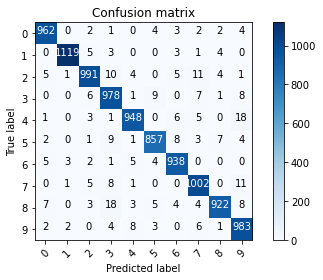

In [41]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
MLP(X_train, y_train, X_test, y_test, 1)

Iteration 1, loss = 0.31433496
Iteration 2, loss = 0.13096526
Iteration 3, loss = 0.09746443
Iteration 4, loss = 0.08289663
Iteration 5, loss = 0.06756179
Iteration 6, loss = 0.06050956
Iteration 7, loss = 0.05404734
Iteration 8, loss = 0.04829666
Iteration 9, loss = 0.04256343
Iteration 10, loss = 0.04180814
hidden layer:2


/opt/tljh/user/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time 44.49815344810486 seconds
Training score is: 0.9885833333333334
Test time 0.42735719680786133 seconds
Test score with is: 0.9707
[[ 970    0    0    1    0    1    3    1    4    0]
 [   0 1127    0    3    0    1    2    0    2    0]
 [   5    1 1012    1    3    0    2    5    3    0]
 [   0    0    3 1000    0    0    0    3    2    2]
 [   1    0    0    0  966    0    4    6    0    5]
 [   3    0    0   31    2  844    7    1    1    3]
 [   9    3    1    1    7    6  929    0    2    0]
 [   1   12   11    9    6    2    0  980    1    6]
 [   6    1    6   14    4    7    4    3  928    1]
 [   2    4    1    9   26    4    1    8    3  951]]
Confusion matrix, without normalization


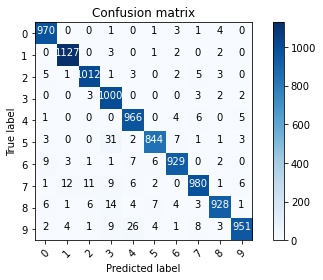

In [42]:
MLP(X_train, y_train, X_test, y_test, 2)

**Discussion**

<table>
  <tr>
    <th>Data</th>
    <th>Classifier</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>Full</td>
    <td>1 hidden-layer MLP</td>
    <td>42.55</td>
    <td>98.68</td>
    <td>0.47</td>
    <td>97</td>
  </tr>
    <tr>
    <td>Full</td>
    <td>2 hidden-layer MLP</td>
    <td>44.50</td>
    <td>98.86</td>
    <td>0.43</td>
    <td>97.07</td>
  </tr>
</table>

Comparing the two perceptron models, MLP with 2 hidden layers has higher training score and test score than MLP with 1 hiddden layer, though it is a little improvement. Also, MLP with 2 hidden layers takes a little more time. Overall, MLP model has better performance than KNN on the full data and it saves more time. However, unlike KNN, the train time of MLP is much longer than the test time, because the optimal weight needs to be found by iterating until it converges, whereas the test step only needs to calculate the weights and find the predictions from them. And from the confusion matrix, we can see different numerical distributions, implying that they have different classification results.

### 3.3 Support Vector Classifier


In [37]:
#SVC model
from sklearn.svm import SVC
def SVC1(train_features, train_labels, test_features, test_labels, k):
    if k==1:
        ## Linear
        clf = SVC(kernel = 'linear', C = 1)
        print(f'linear')
    elif k==2:
        ## cubic polynomial
        clf = SVC(kernel = 'poly',degree = 3, C = 1)
        print(f'cubic polynomial')
    elif k==3:
        ## Radial basis functions
        clf = SVC(kernel = 'rbf', C = 1, gamma = 0.5)
        print(f'Radial basis functions')
        
    start_time = time.time()
    clf.fit(train_features,train_labels)
    train_time = time.time() - start_time
    start_time = time.time()
    score_t = clf.score(train_features,train_labels)
    print(f'Training time {train_time} seconds')
    print(f'Training score is: {score_t}')
    #Evaluate the result
    score = clf.score(test_features,test_labels)
    test_time = time.time() - start_time
    print(f'Test time {test_time} seconds')
    print(f'Test score with is: {score}')
    from sklearn.metrics import confusion_matrix
    y_predict = clf.predict(test_features)
    cfm = confusion_matrix(test_labels, y_predict)
    print (cfm)
    plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix')

linear
Training time 72.78993725776672 seconds
Training score is: 0.9891
Test time 142.79019737243652 seconds
Test score with is: 0.9282928292829283
[[319   0   1   0   0   4   1   1   1   0]
 [  1 364   1   4   0   0   1   0   3   0]
 [  4   3 325   4   5   0   1   5   6   1]
 [  1   2   8 322   0  14   0   1   5   1]
 [  0   0   4   0 320   1   1   4   1   8]
 [  9   0   0   9   0 265   1   2   3   4]
 [  1   2   0   0   3   8 315   0   0   0]
 [  0   1   4   0   6   0   0 312   0   4]
 [  1   3   7  13   0  12   2   2 261   1]
 [  2   4   0   2  17   0   0  15   3 291]]
Confusion matrix, without normalization


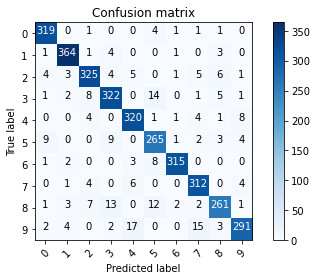

In [38]:
#1/3data, linear
first_index = int(60000/3)
second_index = int(60000/3+10000/3)
X_train, X_test = X[:first_index], X[first_index:second_index]
y_train, y_test = y[:first_index], y[first_index:second_index]
SVC1(X_train, y_train, X_test, y_test, 1)

Radial basis functions
Training time 1156.557676076889 seconds
Training score is: 1.0
Test time 757.5552537441254 seconds
Test score with is: 0.24212421242124213
[[  0   0   0 327   0   0   0   0   0   0]
 [  0 273   0 101   0   0   0   0   0   0]
 [  0   0   0 354   0   0   0   0   0   0]
 [  0   0   0 354   0   0   0   0   0   0]
 [  0   0   0 339   0   0   0   0   0   0]
 [  0   0   0 293   0   0   0   0   0   0]
 [  0   0   0 325   0   0   4   0   0   0]
 [  0   0   0 159   0   0   0 168   0   0]
 [  0   0   0 302   0   0   0   0   0   0]
 [  0   0   0 326   0   0   0   0   0   8]]
Confusion matrix, without normalization


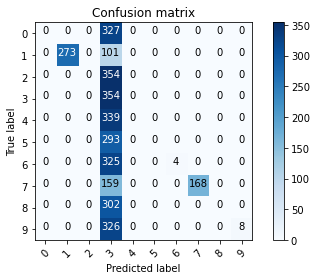

In [39]:
#1/3data, Rbf
SVC1(X_train, y_train, X_test, y_test, 3)

**Discussion**

<table>
  <tr>
    <th>Data</th>
    <th>Classifier</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>1/3</td>
    <td>Linear SVC</td>
    <td>72.78</td>
    <td>98.91</td>
    <td>142.79</td>
    <td>92.83</td>
  </tr>
    <tr>
    <td>1/3</td>
    <td>Radial basis functions SVC</td>
    <td>1085.50</td>
    <td>100</td>
    <td>670.81</td>
    <td>24.21</td>
  </tr>
</table>

Surprisingly, the linear SVM takes less time to train and test compared to the RBF SVM, but it has higher test accuracy. the RBF SVM takes such a long time to train, but actually provides very low test accuracy. Probably because the RBF model is very complex, it requires a long training time. But actually the model is overfitted, resulting in low test accuracy. Therefore, RBF SVM is not a good algorithm in this application.

The confusion matrix is a good representation of the accuracy of the two models. In the linear SVM model, the largest number on the diagonal of the confusion matrix is in dark blue. While in the RBF SVM model, the largest numbers are concentrated in the fourth column. On the one hand this reflects its poor performance, and on the other hand it reflects that it incorrectly identifies most of the characters as the digits 3.

### 3.4 Summary

<table>
  <tr>
    <th>Data</th>
    <th>KNN(K)</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
     <tr>
    <td>Full</td>
    <td>1</td>
    <td>21.59</td>
    <td>100</td>
    <td>1025.75</td>
    <td>96.91</td>
  </tr>
    <tr>
    <td>1/3</td>
    <td>1</td>
    <td>2.55</td>
    <td>100</td>
    <td>525.20</td>
    <td>96.25</td>
  </tr>  
   <tr>
    <td>1/3data, PCA n=40</td>
    <td>1</td>
    <td>0.12</td>
    <td>100</td>
    <td>2.80</td>
    <td>96.72</td>
  </tr>    
</table>
<table>
  <tr>
    <th>Data</th>
    <th>Classifier</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>Full</td>
    <td>1 hidden-layer MLP</td>
    <td>42.55</td>
    <td>98.68</td>
    <td>0.47</td>
    <td>97</td>
  </tr>
    <tr>
    <td>Full</td>
    <td>2 hidden-layer MLP</td>
    <td>44.50</td>
    <td>98.86</td>
    <td>0.43</td>
    <td>97.07</td>
  </tr>
</table>
<table>
  <tr>
    <th>Data</th>
    <th>Classifier</th>
    <th>Training Time</th>
    <th>Training Score</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>1/3</td>
    <td>Linear SVC</td>
    <td>72.78</td>
    <td>98.91</td>
    <td>142.79</td>
    <td>92.83</td>
  </tr>
    <tr>
    <td>1/3</td>
    <td>Radial basis functions SVC</td>
    <td>1085.50</td>
    <td>100</td>
    <td>670.81</td>
    <td>24.21</td>
  </tr>
</table>



For comparison, here I extract the results of the classification experiments for the full dataset and 1/3 dataset. For the MNIST dataset, it seems that the MLP model has the highest accuracy and does not take long (the two MLP models have close scores.) The KNN test results are also good, but PCA is needed to help shorten its running time. In the experiments, the choice of PCA parameters needs to be tried and tuned repeatedly. Linear SVM performs a bit weaker, but still scores above 90. Finally, Rbf SVM takes a long time, but the results are not satisfactory and it is not suitable to be applied to this dataset. In addition, all the above runtimes are related to the server state, and this should be taken into account when designing and selecting the model.